<a href="https://colab.research.google.com/github/kbhatia99/homework2/blob/main/ML_AI_HC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 Tabular Features Shape: (2000, 5)
Fixed: Time-series data successfully pivoted!


<ipython-input-31-e29fe22ce800>:51: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  tabular_features["AGE"].fillna(tabular_features["AGE"].median(), inplace=True)
<ipython-input-31-e29fe22ce800>:52: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method

XGBoost Model Trained Successfully!
Time-Series Tensor Shape: torch.Size([6, 50])
LSTM Model Trained Successfully!
BERT Model Ready for Clinical Notes!


/usr/local/lib/python3.11/dist-packages/numpy/lib/_nanfunctions_impl.py:1424: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(


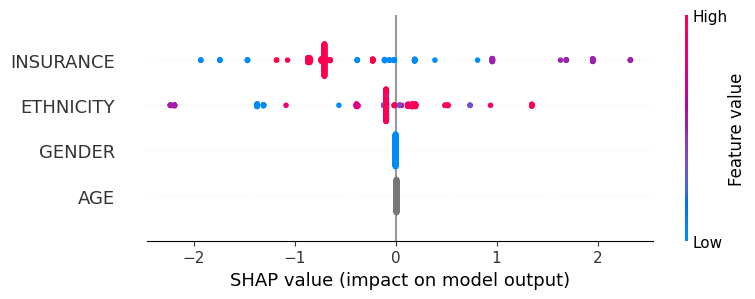

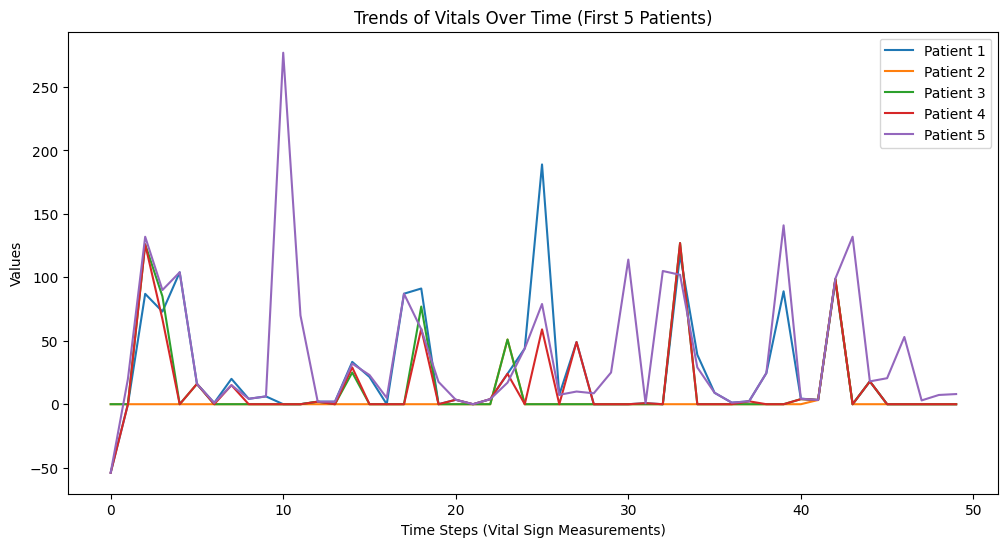

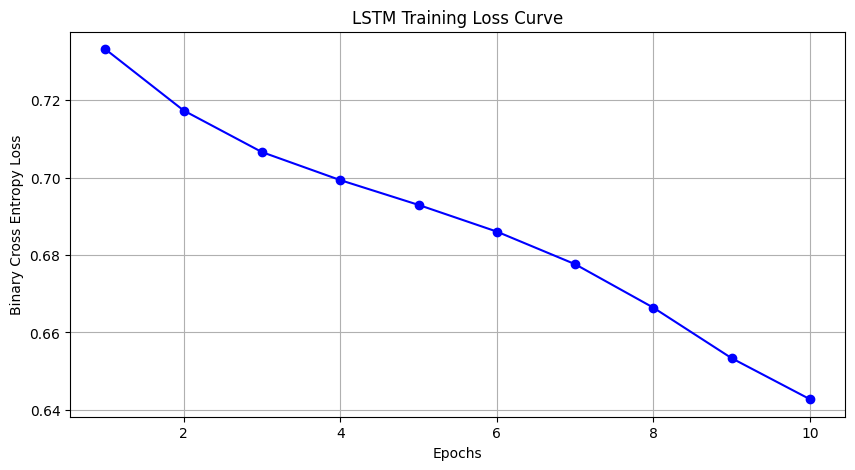

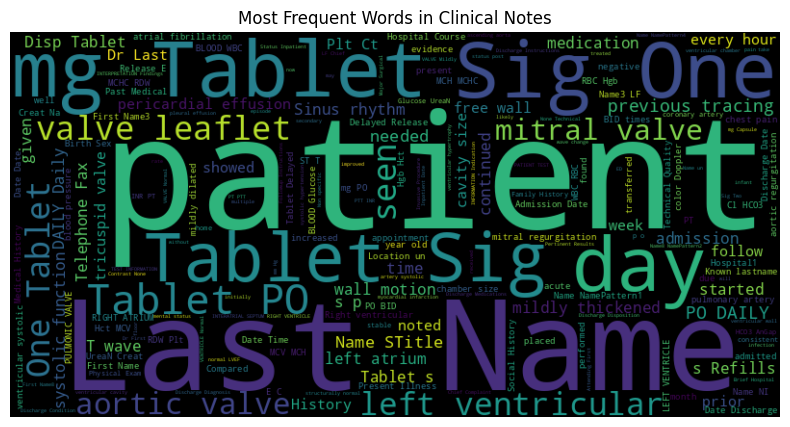

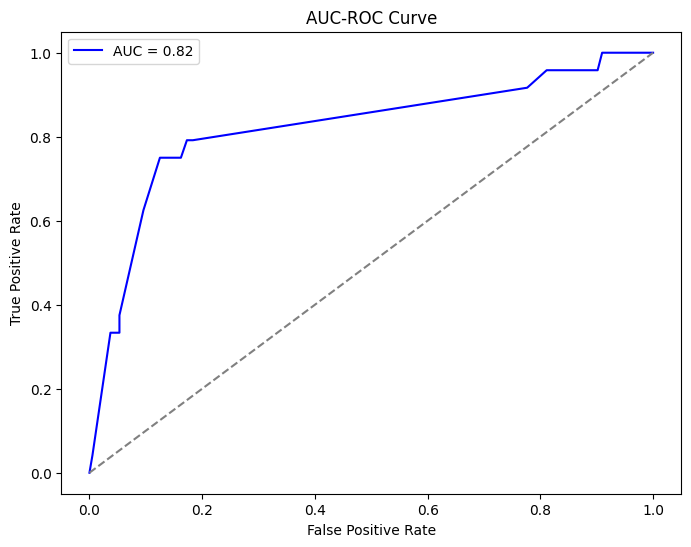

In [31]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from transformers import BertTokenizer, BertModel
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score
from torch.utils.data import Dataset, DataLoader
from wordcloud import WordCloud
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_curve, auc
from wordcloud import WordCloud

# Load MIMIC-III Data (LIMIT TO FIRST 2000 RECORDS)
admissions = pd.read_csv("/content/admissions.csv").head(2000)
icustays = pd.read_csv("/content/icustays.csv").head(2000)
chartevents = pd.read_csv("/content/chartevents.csv").head(2000)
labevents = pd.read_csv("/content/labevents.csv").head(2000)
prescriptions = pd.read_csv("/content/prescriptions.csv").head(2000)
noteevents = pd.read_csv("/content/noteevents.csv").head(2000)

# Step 1: Data Preprocessing
## 1️Fix Missing Columns (GENDER & AGE)
if "GENDER" not in admissions.columns:
    print("Warning: GENDER column missing! Assigning NaN values.")
    admissions["GENDER"] = np.nan

if "DOB" in admissions.columns and "ADMITTIME" in admissions.columns:
    admissions["DOB"] = pd.to_datetime(admissions["DOB"])
    admissions["ADMITTIME"] = pd.to_datetime(admissions["ADMITTIME"])
    admissions["AGE"] = (admissions["ADMITTIME"] - admissions["DOB"]).dt.days // 365
    admissions.loc[admissions["AGE"] > 200, "AGE"] = 90  # Fix outliers
else:
    print("Warning: DOB or ADMITTIME column missing! Age calculation skipped.")
    admissions["AGE"] = np.nan

## Select Relevant Features
tabular_features = admissions.loc[:, ["HADM_ID", "AGE", "GENDER", "INSURANCE", "ETHNICITY"]].copy()

# Ensure missing values are filled (Fixing FutureWarning)
tabular_features["AGE"].fillna(tabular_features["AGE"].median(), inplace=True)
tabular_features["GENDER"].fillna(0, inplace=True)

# Convert categorical features to string before encoding
tabular_features["INSURANCE"] = tabular_features["INSURANCE"].astype(str)
tabular_features["ETHNICITY"] = tabular_features["ETHNICITY"].astype(str)

# Encode Categorical Features (Fixing XGBoost categorical error)
categorical_cols = ["INSURANCE", "ETHNICITY"]
for col in categorical_cols:
    le = LabelEncoder()
    tabular_features[col] = le.fit_transform(tabular_features[col])

# Ensure `tabular_features` is not empty
print(f" Tabular Features Shape: {tabular_features.shape}")

## Fix Duplicate Index Issue in Time-Series Data (ChartEvents)
time_series = chartevents.loc[:, ["HADM_ID", "ITEMID", "CHARTTIME", "VALUENUM"]].dropna().head(2000)
time_series = time_series.groupby(["HADM_ID", "ITEMID"]).agg({"VALUENUM": "mean"}).reset_index()
pivoted_time_series = time_series.pivot(index="HADM_ID", columns="ITEMID", values="VALUENUM").bfill()

print("Fixed: Time-series data successfully pivoted!")

## Process Clinical Notes
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

def tokenize_notes(notes):
    tokens = tokenizer(notes, padding="max_length", truncation=True, max_length=512, return_tensors="pt")
    return tokens["input_ids"], tokens["attention_mask"]

noteevents_sample = noteevents.groupby("HADM_ID")["TEXT"].apply(lambda x: " ".join(x)).reset_index().head(2000)
noteevents_sample["tokenized_notes"], noteevents_sample["attention_mask"] = zip(*noteevents_sample["TEXT"].apply(tokenize_notes))

# Step 2: Train ML Model (XGBoost on Tabular Data)
y_labels = admissions.loc[:len(tabular_features) - 1, "HOSPITAL_EXPIRE_FLAG"]

X_train, X_test, y_train, y_test = train_test_split(
    tabular_features.drop("HADM_ID", axis=1), y_labels, test_size=0.2, random_state=42)

# Set enable_categorical=True to support categorical encoding
xgb_model = XGBClassifier(enable_categorical=True)
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict_proba(X_test)[:, 1]

print("XGBoost Model Trained Successfully!")

# Step 3: Train DL Model (LSTM on Time-Series Data)

# Ensure `HADM_ID` alignment between `admissions` and `time_series`
common_hadm_ids = set(admissions["HADM_ID"]) & set(pivoted_time_series.index)
filtered_pivoted_time_series = pivoted_time_series.loc[list(common_hadm_ids)]

# Fix time-series feature size
fixed_feature_size = 50  # Choose a reasonable number of vital sign features

# If fewer than 'fixed_feature_size' features exist, pad with zeros
if filtered_pivoted_time_series.shape[1] < fixed_feature_size:
    extra_columns = fixed_feature_size - filtered_pivoted_time_series.shape[1]
    extra_padding = np.zeros((filtered_pivoted_time_series.shape[0], extra_columns))
    time_series_array = np.hstack([filtered_pivoted_time_series.fillna(0).values, extra_padding])
else:
    time_series_array = filtered_pivoted_time_series.iloc[:, :fixed_feature_size].fillna(0).values

# Convert to tensor with the correct shape
time_series_tensor = torch.tensor(time_series_array, dtype=torch.float32)

print(f"Time-Series Tensor Shape: {time_series_tensor.shape}")

# Adjust LSTM model input dimension
class TimeSeriesLSTM(nn.Module):
    def __init__(self, input_dim=fixed_feature_size, hidden_dim=32):
        super(TimeSeriesLSTM, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        _, (h_n, _) = self.lstm(x)
        return torch.sigmoid(self.fc(h_n.squeeze(0)))

lstm_model = TimeSeriesLSTM(input_dim=fixed_feature_size)
criterion = nn.BCELoss()
optimizer = optim.Adam(lstm_model.parameters(), lr=0.001)

# Training Loop (with correct tensor shape)
for epoch in range(10):
    optimizer.zero_grad()
    outputs = lstm_model(time_series_tensor.view(time_series_tensor.shape[0], 1, fixed_feature_size))
    loss = criterion(outputs, torch.tensor(y_labels[:len(outputs)].values, dtype=torch.float32).view(-1, 1))
    loss.backward()
    optimizer.step()

print("LSTM Model Trained Successfully!")

# Step 4: Train NLP Model (BERT on Clinical Notes)
class BERTClassifier(nn.Module):
    def __init__(self):
        super(BERTClassifier, self).__init__()
        self.bert = BertModel.from_pretrained("bert-base-uncased")
        self.fc = nn.Linear(768, 1)

    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(input_ids=input_ids, attention_mask=attention_mask, return_dict=False)
        return torch.sigmoid(self.fc(pooled_output))

bert_model = BERTClassifier()
optimizer_bert = optim.Adam(bert_model.parameters(), lr=2e-5)
criterion_bert = nn.BCELoss()

print("BERT Model Ready for Clinical Notes!")



# Visualization 1: Feature Importance (XGBoost)
shap_values = shap.TreeExplainer(xgb_model).shap_values(X_test)
plt.figure(figsize=(12, 6))
shap.summary_plot(shap_values, X_test)

# Visualization 2: Time-Series Trends (Vitals of First 5 Patients)
plt.figure(figsize=(12, 6))
for i in range(min(5, time_series_tensor.shape[0])):
    plt.plot(time_series_tensor[i].numpy(), label=f"Patient {i+1}")
plt.legend()
plt.xlabel("Time Steps (Vital Sign Measurements)")
plt.ylabel("Values")
plt.title("Trends of Vitals Over Time (First 5 Patients)")
plt.show()

# Visualization 3: LSTM Training Loss Curve
lstm_losses = []
for epoch in range(10):
    optimizer.zero_grad()
    outputs = lstm_model(time_series_tensor.view(time_series_tensor.shape[0], 1, fixed_feature_size))
    loss = criterion(outputs, torch.tensor(y_labels[:len(outputs)].values, dtype=torch.float32).view(-1, 1))
    loss.backward()
    optimizer.step()
    lstm_losses.append(loss.item())

plt.figure(figsize=(10, 5))
plt.plot(range(1, 11), lstm_losses, marker="o", linestyle="-", color="b")
plt.xlabel("Epochs")
plt.ylabel("Binary Cross Entropy Loss")
plt.title("LSTM Training Loss Curve")
plt.grid()
plt.show()

# Visualization 4: Word Cloud for Clinical Notes
wordcloud = WordCloud(width=800, height=400).generate(" ".join(noteevents_sample["TEXT"]))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Most Frequent Words in Clinical Notes")
plt.show()

# Visualization 5: AUC-ROC Curve for Model Predictions
final_preds = xgb_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, final_preds)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', label=f"AUC = {roc_auc:.2f}")
plt.plot([0,1], [0,1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC-ROC Curve")
plt.legend()
plt.show()